In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import utils
from BayesModel import BFC, FC

import cProfile
import pstats
device = torch.device('cpu')

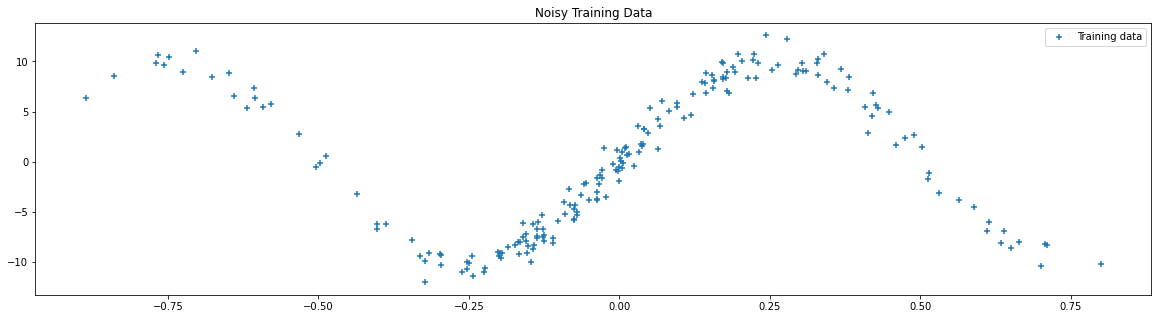

In [313]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 200
noise = 1.0

X1 = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
X2 = np.random.uniform(-2,2, train_size).reshape(-1, 1)
# X2 = np.linspace(4, -4, train_size).reshape(-1, 1)
# np.random.shuffle(X)
y = f(X1*X2, sigma=noise)
y_true = f(X1*X2, sigma=0.0)

plt.scatter(X1*X2, y, marker='+', label='Training data')
# plt.plot(X1*X2, y_true, label='Truth')
plt.title('Noisy Training Data')
plt.legend()

In [307]:
plt.rcParams["figure.figsize"] = (20,5)
def plot_model_pred(model, Y_test, X_test, enums=10, single=False):
    Y_sample = Y_test.detach().numpy()

    # sample test data enums times and average to make a prediction
    Y_pred = torch.zeros(enums, *Y_test.size())
    for j in range(enums):
        Y_pred[j] = model(X_test)

    if single:  # Plots all the predictions of a single data point
        y1 = Y_pred.detach().numpy()[:, 1]
        Y = Y_sample[1]
        pred_mean = y1.mean()
        x = np.linspace(0, 1, len(y1))
        plt.plot(x, y1, "bo", label="all preds for single datapoint")
        plt.plot(x, np.ones_like(x) * Y_sample[1], "r--", lw=5, label="true value")
        plt.plot(x, np.ones_like(x) * pred_mean, "k--", lw=4, label="prediction mean")
        plt.plot(x, pred_mean + np.ones_like(x) * y1.std(), "g--", lw=4, label="prediction std")
        plt.plot(x, pred_mean - np.ones_like(x) * y1.std(), "g--", lw=4)
        plt.xlabel("Prediction count")
        plt.ylabel("Value")
        plt.title("All predictions for a single datapoint after training")
    else:  # Plot mean of all predictions for 40 datapoints, with error bounds
        y1 = Y_pred.detach().numpy()
        pred_mean = y1.mean(0) 
        pred_std = y1.std(0)
        print("mean mean: ", pred_mean.mean())
        print("mean std:", pred_mean.std())
        print("std mean: ", pred_std.mean())
        print("std std:", pred_std.std())
        x = np.arange(len(Y_sample))
        xx = np.c_[x, x, x, x, x, x] if Y_test.size(1) == 3 else np.c_[x, x]
        interval = np.c_[pred_mean - pred_std, pred_mean + pred_std]
        R2 = 1 - ((Y_sample - pred_mean) ** 2).sum() / ((Y_sample - Y_sample.mean()) ** 2).sum()
    
        plt.plot(Y_sample[:40], "bo", ms=8, label="target")
        plt.plot(pred_mean[:40], "ro", ms=4, label="mean")
        plt.plot(xx[:40], interval[:40], "go", ms=4, label="1 sigma")
        plt.title(f"R2: {R2}")
        plt.xlabel("Datapoints")
        plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_model_pred_freq(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()
    Y_pred_sample = model(X_test.to(torch.float)).detach().numpy()

    R2 = 1 - ((Y_sample - Y_pred_sample) ** 2).sum() / ((Y_sample - Y_sample.mean()) ** 2).sum()
    plt.plot(Y_sample[:100], "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample[:100], "ro--", ms=4, label="prediction")
    plt.title(f"R2-score on test data: {R2}")
    plt.legend()
    plt.show()

In [352]:
def train_model(*, model, optimer, x, y, device, epochs, enums=10):
    pbar = tqdm(range(epochs))
    losses = {"total": [], "recon": [], "kl": []}
    loc_grads = {"absmean_0": [], "absmean_2": [], "absmean_4": [], "std_0": [], "std_2": [], "std_4": []}
    rho_grads = {"absmean_0": [], "absmean_2": [], "absmean_4": [], "std_0": [], "std_2": [], "std_4": []}
    grads = {"loc": loc_grads, "rho": rho_grads}
    for epoch in pbar:
        optimer.zero_grad()
            # sample batch enums times during training and average prediction before calculating loss
        outs = torch.zeros(enums, *y.size())
        for j in range(enums):
            outs[j] = model(x, train=True)
        
        pred = outs.mean(0)  # take average of all predictions of each datapoint as final prediction of that datapoint 
        loss_kl = model.kl_reset() / (len(x) * enums)  # normalise by number of batches and enums
        loss_recon = -torch.distributions.Normal(pred, 0.1).log_prob(y).mean()

        loss =  loss_recon + loss_kl
        # loss = loss_recon
        loss.backward()

        optimer.step()
        for layer in [0, 2, 4]:
            grads["loc"][f"absmean_{layer}"].append(model.layers[layer].weight_loc.grad.abs().mean())
            grads["loc"][f"std_{layer}"].append(model.layers[layer].weight_loc.grad.std())
            grads["rho"][f"absmean_{layer}"].append(model.layers[layer].weight_rho.grad.abs().mean())
            grads["rho"][f"std_{layer}"].append(model.layers[layer].weight_rho.grad.std())
            
        pbar.set_description(f"total loss: {loss:.4f}, recon. loss: {loss_recon:.4f}, kl_loss: {loss_kl:.4f}")
        # pbar.set_description(f"total loss: {loss:.4f}, recon. loss: {loss_recon:.4f}")
        losses["total"].append(loss.detach().numpy())
        losses["recon"].append(loss_recon.detach().numpy())
        losses["kl"].append(loss_kl.detach().numpy())


    return losses, grads

def train_model_freq(*, model, optimer, x, y, device, epochs):
    losses = []
    pbar = tqdm(range(epochs))
    loss_fn = torch.nn.MSELoss()
    for epoch in pbar:
        x, y = x.to(device), y.to(device)
        optimer.zero_grad()

        # was simpler to copy code than generalize for non-kl_divergence
        pred = model(x.to(torch.float))
        loss = loss_fn(pred, y.to(torch.float))
        
        loss.backward()
        optimer.step()

        losses.append(loss.detach().numpy())
        pbar.set_description(f"total loss: {loss:.4f}")
    return losses

In [369]:
X = np.concatenate((X1, X2), axis=1)
X = torch.tensor(X)
y = torch.tensor(y)
vnet = BFC(features=2, classes=1, hiddens=[50, 50, 20], prior={"dist": "vmf", "loc": 1, "scale": .1, "record": True, "dist_kwargs": {"k": 100}})
voptimizer = torch.optim.AdamW(vnet.parameters(), lr=.001)
gnet = BFC(features=2, classes=1, hiddens=[20, 20], prior={"dist": "normal", "loc": 0, "scale": .1, "record": True})
goptimizer = torch.optim.AdamW(gnet.parameters(), lr=.1)

fnet = FC(features=2, classes=1, hiddens=[50, 50, 50, 50, 50, 50])
foptimizer = torch.optim.AdamW(fnet.parameters(), lr=0.001)

C:\Users\Khachatur\AppData\Local\Temp\ipykernel_100472\2860971207.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


  0%|          | 0/1500 [00:00<?, ?it/s]

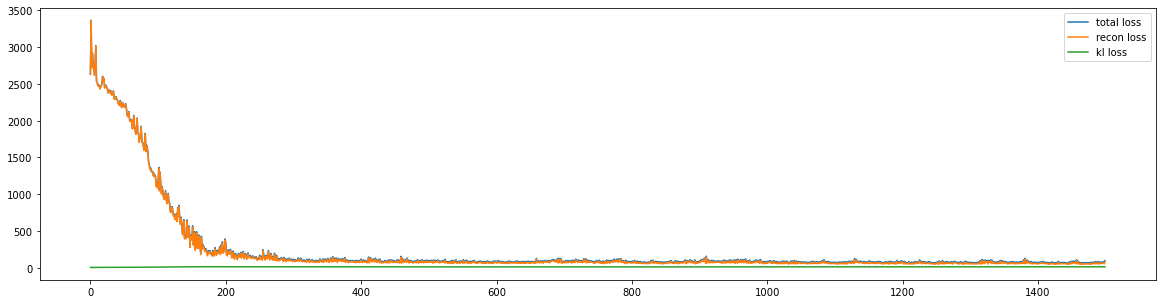

In [375]:
losses, grads = train_model(model=gnet, optimer=goptimizer, x=X, y=y, device=device, epochs=1500, enums=10)
plt.plot(losses["total"][0:], label="total loss")
plt.plot(losses["recon"][0:], label="recon loss")
plt.plot(losses["kl"][0:], label="kl loss")
plt.legend()
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

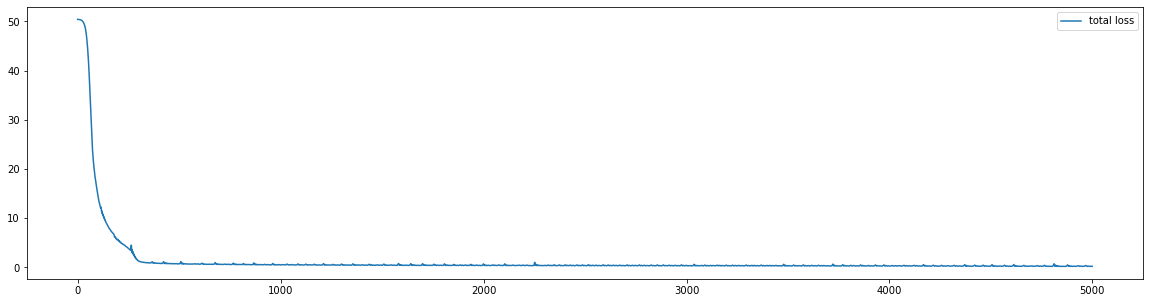

In [370]:
losses = train_model_freq(model=fnet, optimer=foptimizer, x=X, y=y, device=device, epochs=5000)
plt.plot(losses, label="total loss")
plt.legend()
plt.show()

In [367]:
losses, grads = train_model(model=vnet, optimer=voptimizer, x=X, y=y, device=device, epochs=1500, enums=10)
plt.plot(losses["total"][0:], label="total loss")
plt.plot(losses["recon"][0:], label="recon loss")
plt.plot(losses["kl"][0:], label="kl loss")
plt.legend()
plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [386]:
Xt1 = np.linspace(-0.7, 0.7, train_size).reshape(-1, 1)
Xt2 = np.random.uniform(-2,2, train_size).reshape(-1, 1)
X_test = np.concatenate((Xt1, Xt2), axis=1)
X_test = torch.tensor(X_test, dtype=torch.float)

def plot_pred_uncertainty(X1, X2, Xt1, Xt2, y, X_test, gnet):
    X_test = torch.tensor(X_test, dtype=torch.double)
    y_pred_list = []

    for i in tqdm(range(500)):
        y_pred = gnet(X_test).detach().numpy()
        y_pred_list.append(y_pred)

    print(len(y_pred_list))
    print(len(y_pred_list[0]))
    y_preds = np.concatenate(y_pred_list, axis=1)

    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    d = pd.DataFrame((Xt1*Xt2), columns=['X1X2'])
    d['y_mean'] = y_mean
    d['y_sigma'] = y_sigma
    d.sort_values(by='X1X2', inplace=True)

    plt.plot(d.X1X2, d.y_mean, 'r-', label='Predictive mean')
    plt.scatter(X1*X2, y, marker='+', label='Training data')
    plt.fill_between(d.X1X2.ravel(), 
                    d.y_mean + 2 * d.y_sigma, 
                    d.y_mean - 2 * d.y_sigma, 
                    alpha=0.5, label='Epistemic uncertainty')
    plt.title('Prediction')
    plt.legend()

C:\Users\Khachatur\AppData\Local\Temp\ipykernel_100472\1367237926.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.double)


  0%|          | 0/500 [00:00<?, ?it/s]

500
200


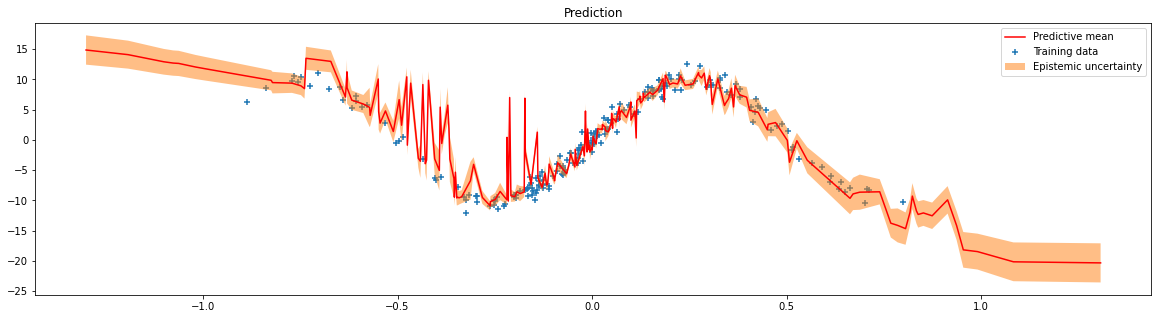

In [387]:
plot_pred_uncertainty(X1, X2, Xt1, Xt2, y, X_test, gnet)

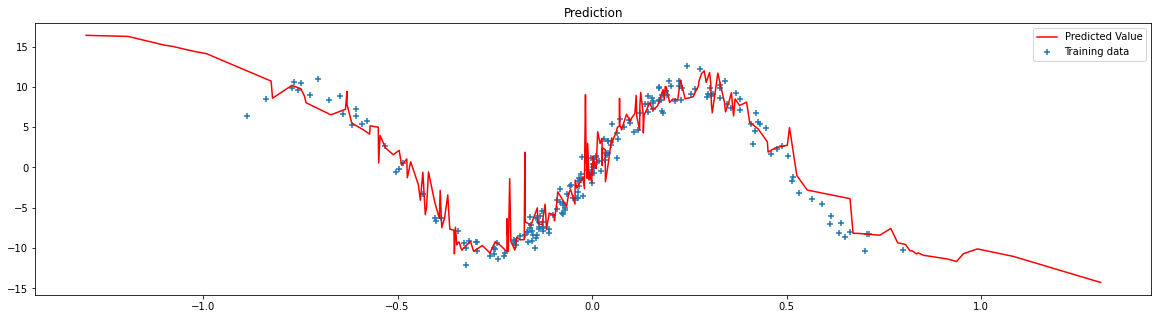

In [391]:
y_pred_list = []

y_pred = fnet(X_test).detach().numpy()

# y_preds = np.concatenate(y_pred_list, axis=1)

d = pd.DataFrame((Xt1*Xt2), columns=['X1X2'])
d['y_pred'] = y_pred
d.sort_values(by='X1X2', inplace=True)

plt.plot(d.X1X2, d.y_pred, 'r-', label='Predicted Value')
plt.scatter(X1*X2, y, marker='+', label='Training data')
plt.title('Prediction')
plt.legend()